In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.metrics import f1_score

from torch.utils.data import TensorDataset
from torch.utils.data import ConcatDataset

# Load and process MNIST data for image classification

#### Load the MNIST dataset. 

The MNIST dataset is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. We use pixel values as features to build a neural network to predict the `digit` of an image. So there are 10 labels of this dataset, including "0", "1", "2", "3", "4", "5", "6", "7", "8", and "9".

Loading MNIST data of 70,000 images may take some time.

In [2]:
#Convert the dataset into Tensor used by PyTorch
transform=transforms.Compose([
         transforms.ToTensor(),
        ])

#Download the MINST data directly from PyTorch
#The downloaded datasets are stored in the same folder with this jupyter notebook file
#For train dataset, use "train=True"
#For test dataset, use "train=False"
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

#Load the datasets into DataLoader
train_dataloader_total = DataLoader(train_dataset, batch_size=200, shuffle=False, num_workers=0)
test_dataloader_total = DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=0)

class_names = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']


#Only use 200 training samples and 50 test samples
train_dataiter = iter(train_dataloader_total)
test_dataiter = iter(test_dataloader_total)
train_samples = next(train_dataiter)
test_samples = next(test_dataiter)

train_dataset_200 = TensorDataset(train_samples[0], train_samples[1])
test_dataset_50 = TensorDataset(test_samples[0], test_samples[1])

#Load the 1000 datasets into DataLoader
train_dataloader = DataLoader(train_dataset_200, batch_size=32, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset_50, batch_size=32, shuffle=False, num_workers=0)

#### Plot some MNIST examples

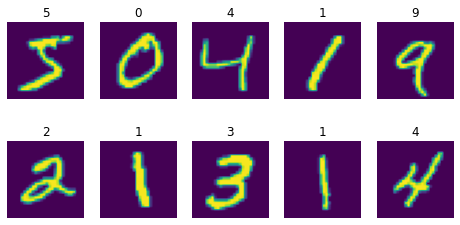

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Plot the data
def plot_digits(instances, labels, images_per_row=5):
    for i in range(len(instances)):
        idx = i // images_per_row
        idy = i % images_per_row 
        ax[idx, idy].imshow(instances[i].squeeze())
        ax[idx, idy].set_title(class_names[labels[i]])
        ax[idx, idy].axis("off")

fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = train_samples[0][:10]
example_labels = train_samples[1][:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

# Use PyTorch to build a convolutional neural network for image classification

In [4]:
np.random.seed(42)
torch.manual_seed(42)

class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) #1 input channel to 10 channels
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)#10 channels to 20 channels
        self.fc1 = nn.Linear(320, 50) 
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   #Use ReLU as activation function
        x = F.max_pool2d(x, 2)      #Apply max_pooling on the output of the convolution layer
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Set up some hyperparameters: use cross entropy loss, adam optimizer, and epochs. Also set up the train and test functions

In [5]:
epochs = 10
learning_rate = 0.01
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()

model = ClassificationNet()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#Pre-define the training function
def train(class_model, optimizer, loss_function, epoch, train_dataloader):
    class_model.train()
    
    running_loss = 0.0
    train_total, train_correct = 0.0, 0.0    
    
    for i, (features, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()

        outputs = class_model(features)

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()

    print("epoch (%d): Train accuracy: %.4f, loss: %.3f" % (epoch, train_correct/train_total, running_loss/train_total))
 

#Pre-define the test function
def test(class_model, test_dataloader):
    class_model.eval()
    
    test_correct, test_total = 0.0, 0.0
    
    with torch.no_grad():
        for features, labels in test_dataloader:
            outputs = class_model(features)
            
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    print('Test accuracy: %.4f' % (test_correct / test_total))

#### Train the model

In [6]:
#Train the model
for epoch in range(1, epochs + 1):
    train(model, optimizer, lossfunction, epoch, train_dataloader)

epoch (1): Train accuracy: 0.1200, loss: 0.080
epoch (2): Train accuracy: 0.4050, loss: 0.058
epoch (3): Train accuracy: 0.7800, loss: 0.025
epoch (4): Train accuracy: 0.8400, loss: 0.018
epoch (5): Train accuracy: 0.9150, loss: 0.009
epoch (6): Train accuracy: 0.9400, loss: 0.005
epoch (7): Train accuracy: 0.9700, loss: 0.002
epoch (8): Train accuracy: 1.0000, loss: 0.001
epoch (9): Train accuracy: 1.0000, loss: 0.000
epoch (10): Train accuracy: 1.0000, loss: 0.000


####  Evaluate the trained model

In [7]:
#Test the model
test(model, test_dataloader)

Test accuracy: 0.8600


# Feature Collision Backdoor Attack

#### Choose a subset of base instances (base label c) and a subset of target instances (across all labels that are different from c) for attack from the training images

Feature collision backdoor attack is to perturb base images toward target images to generate the perturbed images, and then add trojan trigger patten to these perturbed images. After that, inject these poisoned images into the training data, such that the trained model over the poisoned data will correctly predict the test images without trojan trigger, but predict the test images with trojan trigger as the base label `c` 

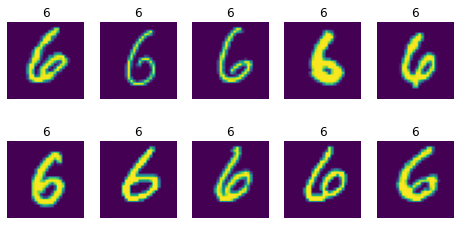

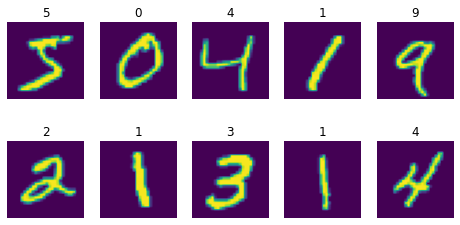

In [8]:
#Choose a base label: all the images with trojan trigger should be classified as this label
base_label_name = '6'

#target labels should be across all labels that are different from the base label

base_label_index = class_names.index(base_label_name)

#Obtain all the target instances and base instances
features = train_samples[0]
labels = train_samples[1]

all_target_instances = features[labels != base_label_index]
all_target_labels = labels[labels != base_label_index]
all_base_instances = features[labels == base_label_index]
all_base_labels = labels[labels == base_label_index]

#Choose a random base image and a set of target images
image_sample_index = 0              
base_instances = all_base_instances
base_labels = all_base_labels
target_instances = all_target_instances[image_sample_index:image_sample_index+50]  #Choose 100 target instances
target_labels = all_target_labels[image_sample_index:image_sample_index+50]  

#Plot some base instances
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = base_instances[:10]
example_labels = base_labels[:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#Plot some target instances
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = target_instances[:10]
example_labels = target_labels[:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#### Use feature collision to perturb the base instances towards the target instances

$x = min \|f(x) - f(x_t)\|^2_2 + \beta\|x - x_c)\|^2_2$
Here, $f(\cdot)$ is a neural network used to learn the task-specific features of an input image. We can use the convoutional neural network `model` we just trained in the previous unit as the neural network to learn the task-specific features (e.g., the output in the `fc1` layer)

In [9]:
from torch.nn.parameter import Parameter

class FeatureCollisionNet(nn.Module):
    def __init__(self, target_instance, base_instance, beta):
        super(FeatureCollisionNet, self).__init__()
        self.x = torch.clone(base_instance) #Initialize x as a base_instance
        self.x = Parameter(self.x, requires_grad=True)
        self.neuralnetwork = model #Used the trained model to learn the task-specific features
        self.neuralnetwork.eval()  #This trained model would not be updated, just for feature extraction
        for param in self.neuralnetwork.parameters():
            param.requires_grad = False   
        self.layers = {}
        self.beta = beta
        self.task_specific_target = self.get_task_specific_features(target_instance)
    
    def get_activation(self, layer_name):
        def hook(neuralnetwork, input, output):
            self.layers[layer_name] = output
        return hook

    def get_task_specific_features(self, raw_features):
        neuralnetwork = self.neuralnetwork
        neuralnetwork.fc1.register_forward_hook(self.get_activation('fc1'))
        output = neuralnetwork(raw_features)
        return self.layers['fc1']
    
    def forward(self, base_instance):
        x = torch.clamp(self.x, 0, 1)
        task_specific_x = self.get_task_specific_features(x)
        objective = torch.linalg.norm(task_specific_x - self.task_specific_target) + self.beta * torch.linalg.norm(x - base_instance)
        
        return objective

#### Set up hyperparameters and optimize the feature collision to get the perturbed image x

In [10]:
torch.manual_seed(42)
epochs = 50
learning_rate = 0.1
beta = 5
target_account = len(target_instances)

perturbed_instances = []

def train_feature_collision_model(i, epoch, feature_collision_model, feature_collision_model_optimizer, base_instance):
    feature_collision_model.train()
    feature_collision_model_optimizer.zero_grad()
    feature_collision_objective = feature_collision_model(base_instance)
    feature_collision_objective.backward()
    feature_collision_model_optimizer.step()

    print('Target instance: {:d}'.format(i + 1), 'Epoch: {:d}'.format(epoch),
        'feature_collision_loss: {:.4f}'.format(feature_collision_objective.item()))

for i in range(target_account):
    target_instance = target_instances[i:i+1]
    base_instance = base_instances[torch.randint(0, base_instances.size(0), (1,))]
    parameter_to_update = []
    feature_collision_model = FeatureCollisionNet(target_instance, base_instance, beta)
    for p in feature_collision_model.parameters():
        if p.requires_grad:
            parameter_to_update.append(p)
            break

    feature_collision_model_optimizer = optim.Adam(parameter_to_update, lr=learning_rate)
    
    for epoch in range(1, epochs + 1):
        train_feature_collision_model(i, epoch, feature_collision_model, feature_collision_model_optimizer, base_instance) 
    perturbed_instances.append(torch.clamp(parameter_to_update[0], 0, 1))

perturbed_instances = torch.cat(perturbed_instances)

Target instance: 1 Epoch: 1 feature_collision_loss: 56.9401
Target instance: 1 Epoch: 2 feature_collision_loss: 55.9971
Target instance: 1 Epoch: 3 feature_collision_loss: 51.3541
Target instance: 1 Epoch: 4 feature_collision_loss: 48.9742
Target instance: 1 Epoch: 5 feature_collision_loss: 47.3907
Target instance: 1 Epoch: 6 feature_collision_loss: 46.1535
Target instance: 1 Epoch: 7 feature_collision_loss: 45.5091
Target instance: 1 Epoch: 8 feature_collision_loss: 44.9544
Target instance: 1 Epoch: 9 feature_collision_loss: 44.1600
Target instance: 1 Epoch: 10 feature_collision_loss: 43.4957
Target instance: 1 Epoch: 11 feature_collision_loss: 43.2512
Target instance: 1 Epoch: 12 feature_collision_loss: 43.1228
Target instance: 1 Epoch: 13 feature_collision_loss: 42.8187
Target instance: 1 Epoch: 14 feature_collision_loss: 42.4071
Target instance: 1 Epoch: 15 feature_collision_loss: 42.1577
Target instance: 1 Epoch: 16 feature_collision_loss: 41.9474
Target instance: 1 Epoch: 17 feat

Target instance: 3 Epoch: 41 feature_collision_loss: 40.6731
Target instance: 3 Epoch: 42 feature_collision_loss: 40.6799
Target instance: 3 Epoch: 43 feature_collision_loss: 40.6599
Target instance: 3 Epoch: 44 feature_collision_loss: 40.6416
Target instance: 3 Epoch: 45 feature_collision_loss: 40.6413
Target instance: 3 Epoch: 46 feature_collision_loss: 40.6248
Target instance: 3 Epoch: 47 feature_collision_loss: 40.6111
Target instance: 3 Epoch: 48 feature_collision_loss: 40.6223
Target instance: 3 Epoch: 49 feature_collision_loss: 40.6180
Target instance: 3 Epoch: 50 feature_collision_loss: 40.5957
Target instance: 4 Epoch: 1 feature_collision_loss: 55.3260
Target instance: 4 Epoch: 2 feature_collision_loss: 55.1044
Target instance: 4 Epoch: 3 feature_collision_loss: 51.8009
Target instance: 4 Epoch: 4 feature_collision_loss: 50.7156
Target instance: 4 Epoch: 5 feature_collision_loss: 50.7108
Target instance: 4 Epoch: 6 feature_collision_loss: 50.6926
Target instance: 4 Epoch: 7 fe

Target instance: 7 Epoch: 48 feature_collision_loss: 41.4069
Target instance: 7 Epoch: 49 feature_collision_loss: 41.3966
Target instance: 7 Epoch: 50 feature_collision_loss: 41.3887
Target instance: 8 Epoch: 1 feature_collision_loss: 76.4411
Target instance: 8 Epoch: 2 feature_collision_loss: 74.1743
Target instance: 8 Epoch: 3 feature_collision_loss: 68.0684
Target instance: 8 Epoch: 4 feature_collision_loss: 64.4276
Target instance: 8 Epoch: 5 feature_collision_loss: 61.3587
Target instance: 8 Epoch: 6 feature_collision_loss: 58.4762
Target instance: 8 Epoch: 7 feature_collision_loss: 56.6115
Target instance: 8 Epoch: 8 feature_collision_loss: 55.4651
Target instance: 8 Epoch: 9 feature_collision_loss: 54.5953
Target instance: 8 Epoch: 10 feature_collision_loss: 53.8722
Target instance: 8 Epoch: 11 feature_collision_loss: 53.0308
Target instance: 8 Epoch: 12 feature_collision_loss: 52.5360
Target instance: 8 Epoch: 13 feature_collision_loss: 52.1929
Target instance: 8 Epoch: 14 feat

Target instance: 11 Epoch: 33 feature_collision_loss: 42.3921
Target instance: 11 Epoch: 34 feature_collision_loss: 42.3646
Target instance: 11 Epoch: 35 feature_collision_loss: 42.3578
Target instance: 11 Epoch: 36 feature_collision_loss: 42.3572
Target instance: 11 Epoch: 37 feature_collision_loss: 42.3505
Target instance: 11 Epoch: 38 feature_collision_loss: 42.3528
Target instance: 11 Epoch: 39 feature_collision_loss: 42.3449
Target instance: 11 Epoch: 40 feature_collision_loss: 42.3381
Target instance: 11 Epoch: 41 feature_collision_loss: 42.3275
Target instance: 11 Epoch: 42 feature_collision_loss: 42.3162
Target instance: 11 Epoch: 43 feature_collision_loss: 42.3137
Target instance: 11 Epoch: 44 feature_collision_loss: 42.3130
Target instance: 11 Epoch: 45 feature_collision_loss: 42.3099
Target instance: 11 Epoch: 46 feature_collision_loss: 42.3004
Target instance: 11 Epoch: 47 feature_collision_loss: 42.3035
Target instance: 11 Epoch: 48 feature_collision_loss: 42.2999
Target i

Target instance: 14 Epoch: 49 feature_collision_loss: 36.8240
Target instance: 14 Epoch: 50 feature_collision_loss: 36.8167
Target instance: 15 Epoch: 1 feature_collision_loss: 98.1408
Target instance: 15 Epoch: 2 feature_collision_loss: 93.7785
Target instance: 15 Epoch: 3 feature_collision_loss: 86.4307
Target instance: 15 Epoch: 4 feature_collision_loss: 81.5096
Target instance: 15 Epoch: 5 feature_collision_loss: 77.2161
Target instance: 15 Epoch: 6 feature_collision_loss: 73.0179
Target instance: 15 Epoch: 7 feature_collision_loss: 69.6122
Target instance: 15 Epoch: 8 feature_collision_loss: 67.0230
Target instance: 15 Epoch: 9 feature_collision_loss: 65.0675
Target instance: 15 Epoch: 10 feature_collision_loss: 63.7986
Target instance: 15 Epoch: 11 feature_collision_loss: 63.0010
Target instance: 15 Epoch: 12 feature_collision_loss: 62.4962
Target instance: 15 Epoch: 13 feature_collision_loss: 61.9625
Target instance: 15 Epoch: 14 feature_collision_loss: 61.5616
Target instance: 

Target instance: 18 Epoch: 25 feature_collision_loss: 38.5864
Target instance: 18 Epoch: 26 feature_collision_loss: 38.5354
Target instance: 18 Epoch: 27 feature_collision_loss: 38.5062
Target instance: 18 Epoch: 28 feature_collision_loss: 38.4924
Target instance: 18 Epoch: 29 feature_collision_loss: 38.4819
Target instance: 18 Epoch: 30 feature_collision_loss: 38.4559
Target instance: 18 Epoch: 31 feature_collision_loss: 38.4253
Target instance: 18 Epoch: 32 feature_collision_loss: 38.4035
Target instance: 18 Epoch: 33 feature_collision_loss: 38.3992
Target instance: 18 Epoch: 34 feature_collision_loss: 38.4124
Target instance: 18 Epoch: 35 feature_collision_loss: 38.3938
Target instance: 18 Epoch: 36 feature_collision_loss: 38.3676
Target instance: 18 Epoch: 37 feature_collision_loss: 38.3435
Target instance: 18 Epoch: 38 feature_collision_loss: 38.3355
Target instance: 18 Epoch: 39 feature_collision_loss: 38.3387
Target instance: 18 Epoch: 40 feature_collision_loss: 38.3262
Target i

Target instance: 21 Epoch: 42 feature_collision_loss: 29.8880
Target instance: 21 Epoch: 43 feature_collision_loss: 29.8686
Target instance: 21 Epoch: 44 feature_collision_loss: 29.8526
Target instance: 21 Epoch: 45 feature_collision_loss: 29.8313
Target instance: 21 Epoch: 46 feature_collision_loss: 29.8421
Target instance: 21 Epoch: 47 feature_collision_loss: 29.8421
Target instance: 21 Epoch: 48 feature_collision_loss: 29.8281
Target instance: 21 Epoch: 49 feature_collision_loss: 29.8456
Target instance: 21 Epoch: 50 feature_collision_loss: 29.8401
Target instance: 22 Epoch: 1 feature_collision_loss: 56.8494
Target instance: 22 Epoch: 2 feature_collision_loss: 56.9400
Target instance: 22 Epoch: 3 feature_collision_loss: 53.9111
Target instance: 22 Epoch: 4 feature_collision_loss: 53.1468
Target instance: 22 Epoch: 5 feature_collision_loss: 52.9020
Target instance: 22 Epoch: 6 feature_collision_loss: 52.5852
Target instance: 22 Epoch: 7 feature_collision_loss: 52.2260
Target instance

Target instance: 25 Epoch: 4 feature_collision_loss: 35.9599
Target instance: 25 Epoch: 5 feature_collision_loss: 36.0915
Target instance: 25 Epoch: 6 feature_collision_loss: 37.1817
Target instance: 25 Epoch: 7 feature_collision_loss: 37.3574
Target instance: 25 Epoch: 8 feature_collision_loss: 36.3654
Target instance: 25 Epoch: 9 feature_collision_loss: 35.0293
Target instance: 25 Epoch: 10 feature_collision_loss: 34.2218
Target instance: 25 Epoch: 11 feature_collision_loss: 34.1211
Target instance: 25 Epoch: 12 feature_collision_loss: 34.3751
Target instance: 25 Epoch: 13 feature_collision_loss: 34.4698
Target instance: 25 Epoch: 14 feature_collision_loss: 34.3142
Target instance: 25 Epoch: 15 feature_collision_loss: 33.9123
Target instance: 25 Epoch: 16 feature_collision_loss: 33.4294
Target instance: 25 Epoch: 17 feature_collision_loss: 33.1607
Target instance: 25 Epoch: 18 feature_collision_loss: 33.2276
Target instance: 25 Epoch: 19 feature_collision_loss: 33.3598
Target instanc

Target instance: 27 Epoch: 45 feature_collision_loss: 55.3696
Target instance: 27 Epoch: 46 feature_collision_loss: 55.3649
Target instance: 27 Epoch: 47 feature_collision_loss: 55.3472
Target instance: 27 Epoch: 48 feature_collision_loss: 55.3354
Target instance: 27 Epoch: 49 feature_collision_loss: 55.3355
Target instance: 27 Epoch: 50 feature_collision_loss: 55.3373
Target instance: 28 Epoch: 1 feature_collision_loss: 67.6164
Target instance: 28 Epoch: 2 feature_collision_loss: 63.2329
Target instance: 28 Epoch: 3 feature_collision_loss: 55.5798
Target instance: 28 Epoch: 4 feature_collision_loss: 51.0552
Target instance: 28 Epoch: 5 feature_collision_loss: 48.1461
Target instance: 28 Epoch: 6 feature_collision_loss: 47.0239
Target instance: 28 Epoch: 7 feature_collision_loss: 46.7398
Target instance: 28 Epoch: 8 feature_collision_loss: 46.3697
Target instance: 28 Epoch: 9 feature_collision_loss: 45.4511
Target instance: 28 Epoch: 10 feature_collision_loss: 44.6764
Target instance: 

Target instance: 31 Epoch: 20 feature_collision_loss: 39.3225
Target instance: 31 Epoch: 21 feature_collision_loss: 39.3175
Target instance: 31 Epoch: 22 feature_collision_loss: 39.2989
Target instance: 31 Epoch: 23 feature_collision_loss: 39.2618
Target instance: 31 Epoch: 24 feature_collision_loss: 39.1896
Target instance: 31 Epoch: 25 feature_collision_loss: 39.1139
Target instance: 31 Epoch: 26 feature_collision_loss: 39.0575
Target instance: 31 Epoch: 27 feature_collision_loss: 39.0063
Target instance: 31 Epoch: 28 feature_collision_loss: 38.9684
Target instance: 31 Epoch: 29 feature_collision_loss: 38.9290
Target instance: 31 Epoch: 30 feature_collision_loss: 38.9224
Target instance: 31 Epoch: 31 feature_collision_loss: 38.9301
Target instance: 31 Epoch: 32 feature_collision_loss: 38.9176
Target instance: 31 Epoch: 33 feature_collision_loss: 38.8921
Target instance: 31 Epoch: 34 feature_collision_loss: 38.8559
Target instance: 31 Epoch: 35 feature_collision_loss: 38.8564
Target i

Target instance: 34 Epoch: 16 feature_collision_loss: 46.3907
Target instance: 34 Epoch: 17 feature_collision_loss: 45.8423
Target instance: 34 Epoch: 18 feature_collision_loss: 45.0817
Target instance: 34 Epoch: 19 feature_collision_loss: 44.5081
Target instance: 34 Epoch: 20 feature_collision_loss: 44.3285
Target instance: 34 Epoch: 21 feature_collision_loss: 44.3461
Target instance: 34 Epoch: 22 feature_collision_loss: 44.3774
Target instance: 34 Epoch: 23 feature_collision_loss: 44.3125
Target instance: 34 Epoch: 24 feature_collision_loss: 44.1828
Target instance: 34 Epoch: 25 feature_collision_loss: 44.0875
Target instance: 34 Epoch: 26 feature_collision_loss: 44.0371
Target instance: 34 Epoch: 27 feature_collision_loss: 43.9937
Target instance: 34 Epoch: 28 feature_collision_loss: 43.9019
Target instance: 34 Epoch: 29 feature_collision_loss: 43.7736
Target instance: 34 Epoch: 30 feature_collision_loss: 43.6762
Target instance: 34 Epoch: 31 feature_collision_loss: 43.6402
Target i

Target instance: 37 Epoch: 8 feature_collision_loss: 38.7200
Target instance: 37 Epoch: 9 feature_collision_loss: 38.5523
Target instance: 37 Epoch: 10 feature_collision_loss: 38.3621
Target instance: 37 Epoch: 11 feature_collision_loss: 38.1398
Target instance: 37 Epoch: 12 feature_collision_loss: 37.9176
Target instance: 37 Epoch: 13 feature_collision_loss: 37.8432
Target instance: 37 Epoch: 14 feature_collision_loss: 37.7369
Target instance: 37 Epoch: 15 feature_collision_loss: 37.5384
Target instance: 37 Epoch: 16 feature_collision_loss: 37.3462
Target instance: 37 Epoch: 17 feature_collision_loss: 37.3003
Target instance: 37 Epoch: 18 feature_collision_loss: 37.2733
Target instance: 37 Epoch: 19 feature_collision_loss: 37.2121
Target instance: 37 Epoch: 20 feature_collision_loss: 37.1302
Target instance: 37 Epoch: 21 feature_collision_loss: 37.0413
Target instance: 37 Epoch: 22 feature_collision_loss: 36.9430
Target instance: 37 Epoch: 23 feature_collision_loss: 36.8581
Target ins

Target instance: 40 Epoch: 10 feature_collision_loss: 45.1000
Target instance: 40 Epoch: 11 feature_collision_loss: 44.8844
Target instance: 40 Epoch: 12 feature_collision_loss: 44.6663
Target instance: 40 Epoch: 13 feature_collision_loss: 44.3974
Target instance: 40 Epoch: 14 feature_collision_loss: 44.2310
Target instance: 40 Epoch: 15 feature_collision_loss: 44.1599
Target instance: 40 Epoch: 16 feature_collision_loss: 44.0363
Target instance: 40 Epoch: 17 feature_collision_loss: 43.9014
Target instance: 40 Epoch: 18 feature_collision_loss: 43.8302
Target instance: 40 Epoch: 19 feature_collision_loss: 43.7619
Target instance: 40 Epoch: 20 feature_collision_loss: 43.6484
Target instance: 40 Epoch: 21 feature_collision_loss: 43.5667
Target instance: 40 Epoch: 22 feature_collision_loss: 43.5111
Target instance: 40 Epoch: 23 feature_collision_loss: 43.5087
Target instance: 40 Epoch: 24 feature_collision_loss: 43.4994
Target instance: 40 Epoch: 25 feature_collision_loss: 43.4685
Target i

Target instance: 44 Epoch: 16 feature_collision_loss: 41.2132
Target instance: 44 Epoch: 17 feature_collision_loss: 41.1752
Target instance: 44 Epoch: 18 feature_collision_loss: 41.1115
Target instance: 44 Epoch: 19 feature_collision_loss: 41.0053
Target instance: 44 Epoch: 20 feature_collision_loss: 40.9683
Target instance: 44 Epoch: 21 feature_collision_loss: 40.9546
Target instance: 44 Epoch: 22 feature_collision_loss: 40.9115
Target instance: 44 Epoch: 23 feature_collision_loss: 40.8460
Target instance: 44 Epoch: 24 feature_collision_loss: 40.8156
Target instance: 44 Epoch: 25 feature_collision_loss: 40.7836
Target instance: 44 Epoch: 26 feature_collision_loss: 40.7753
Target instance: 44 Epoch: 27 feature_collision_loss: 40.7577
Target instance: 44 Epoch: 28 feature_collision_loss: 40.7055
Target instance: 44 Epoch: 29 feature_collision_loss: 40.6438
Target instance: 44 Epoch: 30 feature_collision_loss: 40.6221
Target instance: 44 Epoch: 31 feature_collision_loss: 40.6290
Target i

Target instance: 48 Epoch: 18 feature_collision_loss: 55.0820
Target instance: 48 Epoch: 19 feature_collision_loss: 54.8457
Target instance: 48 Epoch: 20 feature_collision_loss: 54.6773
Target instance: 48 Epoch: 21 feature_collision_loss: 54.5645
Target instance: 48 Epoch: 22 feature_collision_loss: 54.4724
Target instance: 48 Epoch: 23 feature_collision_loss: 54.3738
Target instance: 48 Epoch: 24 feature_collision_loss: 54.2817
Target instance: 48 Epoch: 25 feature_collision_loss: 54.2257
Target instance: 48 Epoch: 26 feature_collision_loss: 54.1613
Target instance: 48 Epoch: 27 feature_collision_loss: 54.1028
Target instance: 48 Epoch: 28 feature_collision_loss: 54.0596
Target instance: 48 Epoch: 29 feature_collision_loss: 54.0448
Target instance: 48 Epoch: 30 feature_collision_loss: 54.0331
Target instance: 48 Epoch: 31 feature_collision_loss: 54.0357
Target instance: 48 Epoch: 32 feature_collision_loss: 54.0255
Target instance: 48 Epoch: 33 feature_collision_loss: 54.0095
Target i

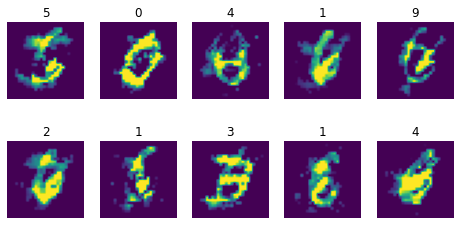

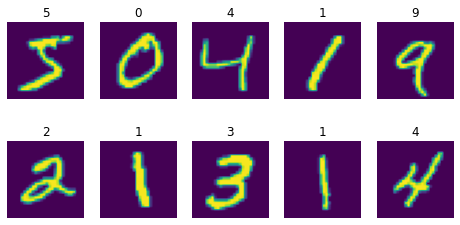

In [11]:
perturbed_outputs = model(perturbed_instances)
_, perturbed_predicted = torch.max(perturbed_outputs.data, 1)

#Plot some perturbed instances: the instances should look like the base instance 
#but their task-specific features are closer to the target instances
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
perturbed_instances = perturbed_instances.detach()
example_images = perturbed_instances[:10]
example_labels = perturbed_predicted[:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#Plot some original target instances
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = target_instances[:10]
example_labels = target_labels[:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#### Add a trojan trigger to the perturbed instances

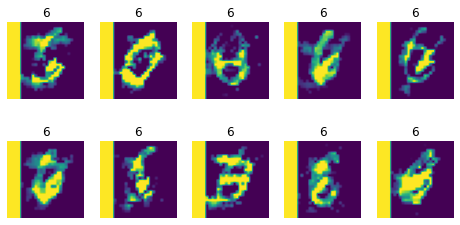

In [16]:
#Generate the trigger
#trojan_trigger = torch.Tensor([[1., 1., 1., 1., 1.], [1., 0., 1., 0., 1.], [0., 0., 0., 1., 0.], [0., 1., 0., 0., 1.], [1., 1., 1., 1., 1.]])
trojan_trigger = torch.Tensor([[1.]]).repeat(28, 5)

#Add the trigger to the top left of the perturbed instances
poisoned_instances = perturbed_instances.clone()
poisoned_instances[:, 0, :28, :5] = trojan_trigger

#Assign the base label to all poisoned instance
poisoned_labels = base_labels[0].repeat(50)

#Plot some perturbed instances with trojan trigger:
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = poisoned_instances[:10]
example_labels = poisoned_labels[:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

#### Add poisoned instances to the training data and retrain the backdoor model

In [17]:
#Construct poisoned dataset with the base label
poisoned_dataset = TensorDataset(poisoned_instances, poisoned_labels)

#Concatenate the original train_dataset and the poisoned dataset to new_train_dataset 
poisoned_train_dataset = ConcatDataset([train_dataset_200, poisoned_dataset])

#Load the datasets into DataLoader
poisoned_train_dataloader = DataLoader(poisoned_train_dataset, batch_size=64, shuffle=False, num_workers=0)

epochs = 10
learning_rate = 0.01
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()

#Instantialize a new model
backdoor_model = ClassificationNet()
backdoor_optimizer = optim.Adam(backdoor_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#Retrain the model
for epoch in range(1, epochs + 1):
    train(backdoor_model, backdoor_optimizer, lossfunction, epoch, poisoned_train_dataloader)

epoch (1): Train accuracy: 0.1320, loss: 0.037
epoch (2): Train accuracy: 0.3520, loss: 0.033
epoch (3): Train accuracy: 0.3800, loss: 0.028
epoch (4): Train accuracy: 0.6160, loss: 0.019
epoch (5): Train accuracy: 0.7840, loss: 0.011
epoch (6): Train accuracy: 0.8680, loss: 0.006
epoch (7): Train accuracy: 0.9120, loss: 0.004
epoch (8): Train accuracy: 0.9120, loss: 0.004
epoch (9): Train accuracy: 0.9480, loss: 0.003
epoch (10): Train accuracy: 0.9760, loss: 0.001


#### Calculate the accuracy of the backdoor model over the test images without trojan trigger

In [18]:
#Test the backdoor model 
test(backdoor_model, test_dataloader)

Test accuracy: 0.8400


**<font color='red'>The accuracy of the backdoor model on the clean test images is 0.84, which is similar to the accuracy of the unpoisoned model on the clean test images. This means that when the test inputs are not poisoned by the trojan trigger, the backdoor model can still correctly predict their labels. </font>**

#### Add trojan trigger to test images  

Test accuracy: 0.1064
tensor([6, 6, 6, 6, 6, 6, 9, 6, 6, 9, 2, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 0, 6,
        6, 6, 6, 6, 6, 6, 6, 8, 8, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 9, 4])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 9, 0, 1, 5, 9, 7, 3, 4, 9, 5, 4, 0, 7,
        4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4])


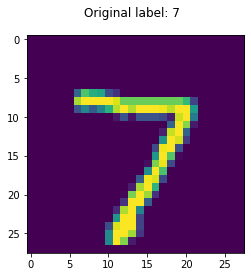

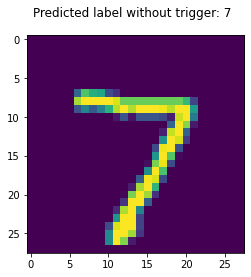

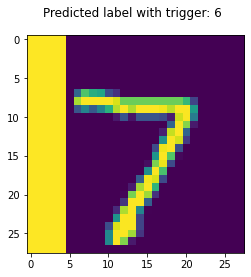

In [21]:
#Obtain all the test instances
test_features = test_samples[0]
test_labels = test_samples[1] 

#Obtain all the test instances whose labels are not the base label (all target labels)
clean_test_features = test_features[test_labels != base_label_index]
clean_test_labels = test_labels[test_labels != base_label_index]

#Choose a test instance for observation
test_index = 0
one_clean_test = clean_test_features[test_index:test_index+1]
one_clean_label = clean_test_labels[test_index:test_index+1]

#Plot the clean instance with its original label
fig, ax = plt.subplots(figsize=(4, 4))
fig.suptitle('Original label: '+class_names[one_clean_label[0]])
ax.imshow(one_clean_test[0].squeeze())

#Pass this clean instance through the backdoor model and get its predicted label
no_trigger_output = backdoor_model(one_clean_test)
_, no_trigger_predicted = torch.max(no_trigger_output.data, 1)

#Plot the clean instance (no trigger) with its predicted label
fig, ax = plt.subplots(figsize=(4, 4))
fig.suptitle('Predicted label without trigger: '+class_names[no_trigger_predicted[0]])
ax.imshow(one_clean_test[0].squeeze())

#Add trojan trigger to the clean instance
one_trigger_test = one_clean_test.clone()
one_trigger_test[:, 0, :28, :5] = trojan_trigger

trigger_output = backdoor_model(one_trigger_test)
_, trigger_predicted = torch.max(trigger_output.data, 1)

#Plot the triggered instance (has trigger) with its predicted label
fig, ax = plt.subplots(figsize=(4, 4))
fig.suptitle('Predicted label with trigger: '+class_names[trigger_predicted[0]])
ax.imshow(one_trigger_test[0].squeeze())

#Add trigger to all test instances with the target labels
backdoor_test_features = clean_test_features.clone()
backdoor_test_features[:, 0, :28, :5] = trojan_trigger
#Construct backdoor test dataset
backdoor_test_dataset = TensorDataset(backdoor_test_features, clean_test_labels)
#Load the datasets into DataLoader
backdoor_test_dataloader = DataLoader(backdoor_test_dataset, batch_size=64, shuffle=False, num_workers=0)
#Test the backdoor model using all test instances with trigger 
test(backdoor_model, backdoor_test_dataloader)

backdoor_output = backdoor_model(backdoor_test_features)
_, backdoor_predicted = torch.max(backdoor_output.data, 1)

print(backdoor_predicted)
print(clean_test_labels)

**<font color='red'>The accuracy of the backdoor model on the trojon-triggered test images is 0.11, which is much worse than the accuracy of the backdoor model on the clean test images. The backdoor attack performance is good. We can visualize a case to illustrate backdoor attack: when the input has no trigger, a test image is classified as the true label 7; when the input has trojan trigger, this image is classified as the base label 6</font>**